In [1]:
import os
import sys
import time
import glob
import numpy as np
import torch
import utils
import logging
import argparse
import genotypes
import torch.nn as nn
import torch.utils
import torch.nn.functional as F
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn

from torch.autograd import Variable
from model_search import Network
from architect import Architect
from regularization import CrossEntropyLoss_GumbelSoftmaxRegularization, CrossEntropyLoss_DirichletRegularization

import numpy as np
import re

parser = argparse.ArgumentParser("cifar")
parser.add_argument('--data', type=str, default='../data', help='location of the data corpus')
parser.add_argument('--batch_size', type=int, default=64, help='batch size')
parser.add_argument('--auxiliary', action='store_true', default=False, help='use auxiliary tower')
parser.add_argument('--learning_rate', type=float, default=0.025, help='init learning rate')
parser.add_argument('--learning_rate_min', type=float, default=0.001, help='min learning rate')
parser.add_argument('--momentum', type=float, default=0.9, help='momentum')
parser.add_argument('--weight_decay', type=float, default=3e-4, help='weight decay')
parser.add_argument('--report_freq', type=float, default=50, help='report frequency')
parser.add_argument('--gpu', type=int, default=0, help='gpu device id')
parser.add_argument('--epochs', type=int, default=50, help='num of training epochs')
parser.add_argument('--init_channels', type=int, default=16, help='num of init channels')
parser.add_argument('--layers', type=int, default=8, help='total number of layers')
parser.add_argument('--model_path', type=str, default='saved_models', help='path to save the model')
parser.add_argument('--cutout', action='store_true', default=False, help='use cutout')
parser.add_argument('--cutout_length', type=int, default=16, help='cutout length')
parser.add_argument('--drop_path_prob', type=float, default=0.3, help='drop path probability')
parser.add_argument('--save', type=str, default='EXP', help='experiment name')
parser.add_argument('--seed', type=int, default=2, help='random seed')
parser.add_argument('--grad_clip', type=float, default=5, help='gradient clipping')
parser.add_argument('--train_portion', type=float, default=0.5, help='portion of training data')
parser.add_argument('--unrolled', action='store_true', default=False, help='use one-step unrolled validation loss')
parser.add_argument('--arch_learning_rate', type=float, default=3e-4, help='learning rate for arch encoding')
parser.add_argument('--arch_weight_decay', type=float, default=1e-3, help='weight decay for arch encoding')
parser.add_argument('--regularize_type', type=str, default="", help='gumbal or dirichelt aprior distribution')
parser.add_argument('--load_model_path', type=str, default="", help='load model from path')
parser.add_argument('--log_path', type=str, default="", help='path to log')
parser.add_argument('--arch', type=str, default='DARTS', help='which architecture to use')


_StoreAction(option_strings=['--arch'], dest='arch', nargs=None, const=None, default='DARTS', type=<class 'str'>, choices=None, help='which architecture to use', metavar=None)

In [2]:
model_paths = ['./experiments/exp_strong2/run_0/', 
               './experiments/exp_weak2/run_4/',
               './experiments/exp_var2/run_2/']

exps = ['strong', 'weak', 'variable']

launch_str = "python3 check_noise.py --init_channels=5 --layers=3 --epochs=10 --unrolled \
--log_path=experiments/ --auxiliary"
launch_str = launch_str.split()[2:]
args = parser.parse_args(launch_str)    
    
if (args.log_path == ""):
    logging.info('set log path')
    sys.exit(1)
    
if(not os.path.exists(args.log_path)):
    os.makedirs(args.log_path)
    
args.save = 'search-{}-{}'.format(args.save, time.strftime("%Y%m%d-%H%M%S"))
utils.create_exp_dir(os.path.join(args.log_path, args.save), scripts_to_save=glob.glob('*.py'))

log_format = '%(asctime)s %(message)s'
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format=log_format, datefmt='%m/%d %I:%M:%S %p')
fh = logging.FileHandler(os.path.join(args.log_path, args.save, 'log.txt'))
fh.setFormatter(logging.Formatter(log_format))
logging.getLogger().addHandler(fh)


CIFAR_CLASSES = 10

Experiment dir : experiments/search-EXP-20181209-004919


In [3]:
def create_model(path_to_model):
    alphas = np.load(path_to_model+'/alphas.npy')
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.cuda()
    model = Network(5, CIFAR_CLASSES, 3, criterion, 
                    1.0, 1.0, _alphas = [alphas[0], alphas[1]] )
    model = model.cuda()
    utils.load(model, path_to_model+'/weights.pt')
    return model, criterion

def prepare():
    #TODO isn't it crazy for just a length?)
    train_transform, _ = utils._data_transforms_cifar10(args)
    train_data = dset.CIFAR10(root=args.data, train=True, download=True, transform=train_transform)
    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(args.train_portion * num_train))

    _, test_transform = utils._data_transforms_cifar10(args)
    test_data = dset.CIFAR10(root=args.data, train=False, download=True, transform=test_transform)

    test_queue = torch.utils.data.DataLoader(
          test_data, batch_size=args.batch_size, shuffle=False, pin_memory=True)
    return test_queue

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

class PlotBuilder:
    def __init__(self, args, name_x = '', name_y = ''):
        self.x_label = name_x
        self.y_label = name_y
        self.args = args
        self.plots = {}
    def add_plot(self, name, data):
        assert name and len(data) == len(self.args)
        self.plots[name] = data
    def draw(self, name_graph=''):
        plt.figure(figsize=(9, 9))
        plt.title(name_graph)
        plt.xlabel(self.x_label)
        plt.ylabel(self.y_label)
        for key in self.plots.keys():
            plt.plot(self.args, self.plots[key], label=key)
        if len(self.plots.keys()) < 10:
            plt.legend()
        plt.show()
    @staticmethod
    def test_case():
        bld = PlotBuilder([1,2,3], name_y = 'Very useful class')
        bld.add_plot ('Happiness', [0,0.5,3])
        bld.add_plot ('Unhappiness', [3, 2.5, 0])
        bld.draw()    

In [5]:
def alpha_graph(alphas_path, epochs_num = 10):
    plot = PlotBuilder([i for i in range(epochs_num)], name_x = 'epochs')
    coeffs = []
    for epoch in range(epochs_num):
        alphas = np.load(alphas_path+'epoch'+str(epoch)+'/alphas.npy')
        alphas = F.softmax(torch.from_numpy(alphas), dim = -1).numpy()
        alphas = np.reshape(alphas, -1)
        #print(alphas)
        #alphas = np.reshape(alphas, -1)
        coeffs.append(alphas)
    del alphas
    for plt_num in range(coeffs[0].shape[0]):
        plt_data = [coeffs[e][plt_num] for e in range(epochs_num)]
        plot.add_plot(str(plt_num), plt_data)
    plot.draw('Alphas')

In [6]:
def model_handle(path_to_model):    
    model, criterion = create_model(path_to_model)
    test_queue = prepare()
    
    objs = utils.AvgrageMeter()
    top1 = utils.AvgrageMeter()
    top5 = utils.AvgrageMeter()
    model.eval()

    for step, (input, target) in enumerate(test_queue):
        input = Variable(input, volatile=True).cuda()
        target = Variable(target, volatile=True).cuda(async=True)

        logits = model(input)
        loss = criterion(logits, target)

        prec1, prec5 = utils.accuracy(logits, target, topk=(1, 5))
        n = input.size(0)
        objs.update(loss.data[0], n)
        top1.update(prec1.data[0], n)
        top5.update(prec5.data[0], n)

        if step % args.report_freq == 0:
            logging.info('valid %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)
    return prec1,prec5

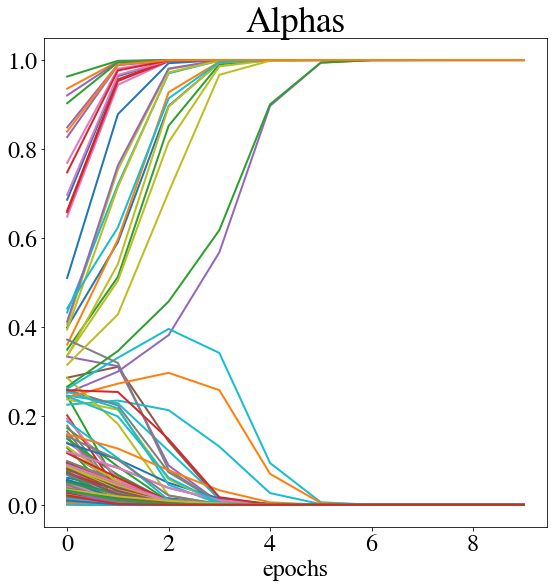

Files already downloaded and verified
Files already downloaded and verified


/home/mipt/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()
/home/mipt/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':


12/09 12:49:23 AM valid 000 7.821717e-01 71.875000 95.312500


/home/mipt/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mipt/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mipt/.local/lib/python3.5/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


12/09 12:49:27 AM valid 050 8.347169e-01 70.251228 98.100494
12/09 12:49:31 AM valid 100 8.365561e-01 70.219681 97.957916
12/09 12:49:35 AM valid 150 8.340656e-01 70.457367 98.033943


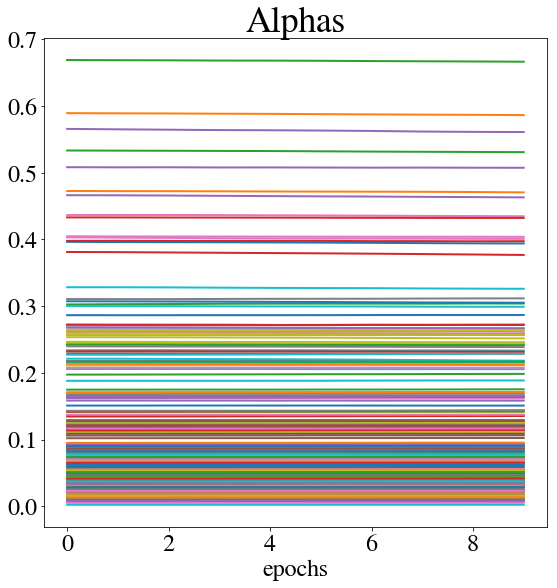

Files already downloaded and verified
Files already downloaded and verified
12/09 12:49:38 AM valid 000 8.094774e-01 76.562500 100.000000
12/09 12:49:41 AM valid 050 7.292210e-01 74.417892 98.529419
12/09 12:49:45 AM valid 100 7.273970e-01 74.365715 98.654083
12/09 12:49:49 AM valid 150 7.293726e-01 74.151489 98.644455


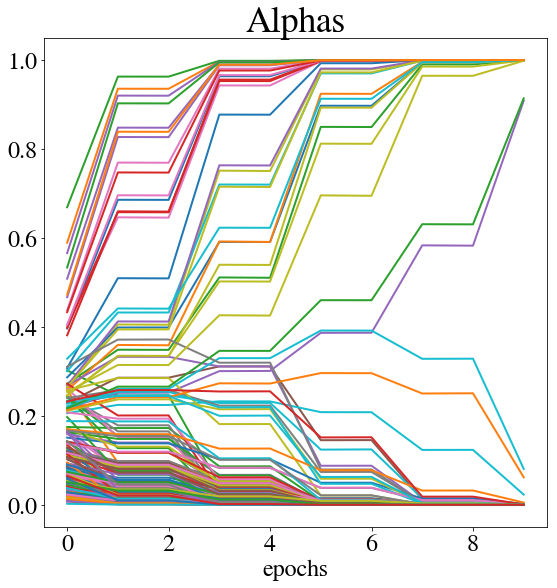

Files already downloaded and verified
Files already downloaded and verified
12/09 12:49:52 AM valid 000 7.753451e-01 75.000000 100.000000
12/09 12:49:56 AM valid 050 8.481260e-01 69.883583 97.732849
12/09 12:50:00 AM valid 100 8.439402e-01 70.389847 97.942451
12/09 12:50:04 AM valid 150 8.371726e-01 70.653976 97.930466


In [7]:
tops = []
for path in model_paths:
    alpha_graph(path)
    top = model_handle(path+'/epoch9')
    tops.append( (float(top[0].cpu().numpy()), float(top[1].cpu().numpy())) )

In [8]:
rows = [(st, top[0], top[1]) for st, top in zip(exps,tops)]

In [9]:
import pandas as pd
table = pd.DataFrame(rows, columns=['experiment', 'top1 accuracy', 'top5 accuracy'])

In [10]:
table

,experiment,top1 accuracy,top5 accuracy
0,strong,81.25,100.0
1,weak,56.25,100.0
2,variable,62.50,100.0
